In [31]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import h3pandas
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('../trophic_niches.txt', 'r') as f:
    niches = f.read().strip().split('\n')
    
niches
    

['all',
 'Trophic_Niche_Aquatic_predator',
 'Trophic_Niche_Frugivore',
 'Trophic_Niche_Granivore',
 'Trophic_Niche_Herbivore_aquatic',
 'Trophic_Niche_Herbivore_terrestrial',
 'Trophic_Niche_Invertivore',
 'Trophic_Niche_Nectarivore',
 'Trophic_Niche_Omnivore',
 'Trophic_Niche_Scavenger',
 'Trophic_Niche_Vertivore',
 'Trophic_Level_Carnivore',
 'Trophic_Level_Herbivore',
 'Trophic_Level_Omnivore',
 'Trophic_Level_Scavenger']

In [32]:
all_dat = []
for niche in niches:
    print(niche)
    all_year_set = list(range(2010, 2021))
    target_year_set = list(range(2016, 2021))
    season_set = ['spring','fall']
    for year in tqdm(all_year_set):
        for season in season_set:
            file1_path = f'../../data/D02.wave_peak/{season}_max_birdwave_day_{niche}_{year}_10_40_20_50.csv'
            file2_path = f'../../data/D02.wave_peak/{season}_max_birdwave_day_{niche}_{year}_10_100_30_80.csv'
            
            if not (os.path.exists(file1_path) and os.path.exists(file2_path)):
                print(f'Not {niche}')
            
            file1 = pd.read_csv(file1_path)
            file1['source_model'] = '10_40_20_50'
            
            if year in target_year_set:
                file2 = pd.read_csv(file2_path)
                grid_set = file2.h3_02.unique()
                event_logger = []
                        
                for grid in grid_set:
                    sub_file1 = file1[(file1['h3_02']==grid)]
                    task = None
                    if len(sub_file1)==0:
                        task = 'to_combine'
                    else:
                        if len(sub_file1)>1:
                            raise ValueError('more than 1 row?')
                        else:
                            if np.isnan(sub_file1['mean_DOY_peak'].iloc[0]):
                                task = 'to_fill'
                            else:
                                task = 'all_good'

                    if task == 'all_good':
                        continue

                    candidate = file2[(file2['h3_02']==grid)]
                    candidate['source_model'] = '10_100_30_80'
                    if len(candidate)==0:
                        continue
                    else:
                        if len(candidate)>1:
                            raise ValueError('candidate more than 1 row?')
                        else:
                            if np.isnan(candidate['mean_DOY_peak'].iloc[0]):
                                continue
                            else:
                                if task == 'to_combine':
                                    file1 = pd.concat([file1, candidate], axis=0).reset_index(drop=True)
                                elif task == 'to_fill':
                                    file1.loc[sub_file1.index,:] = candidate.values
                                    file1.loc[sub_file1.index,'source_model'] = '10_100_30_80'
                                else:
                                    print(task)
                                    raise

                                event_logger.append({
                                    'grid':grid,
                                    'year':int(year),
                                    'season':season
                                })
                            
            file1['season'] = season
            file1['year'] = year
            file1['niche_or_level'] = niche
            all_dat.append(file1)

all_dat = pd.concat(all_dat, axis=0).reset_index(drop=True)
    

all


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Aquatic_predator


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Frugivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Granivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Herbivore_aquatic


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Herbivore_terrestrial


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Invertivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Nectarivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Omnivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Scavenger


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Niche_Vertivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Level_Carnivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Level_Herbivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Level_Omnivore


  0%|          | 0/11 [00:00<?, ?it/s]

Trophic_Level_Scavenger


  0%|          | 0/11 [00:00<?, ?it/s]

<Axes: >

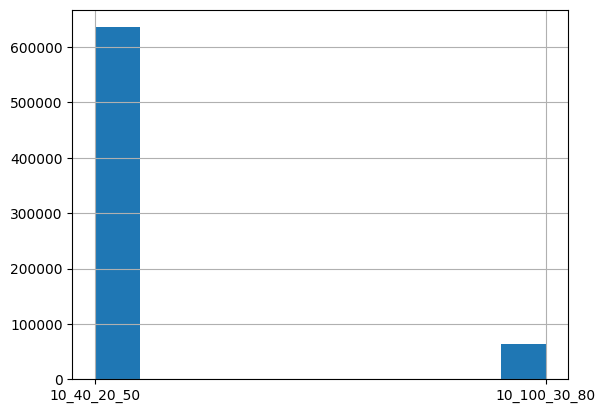

In [33]:
all_dat['source_model'].hist()


In [38]:
all_dat = all_dat.dropna(subset=['mean_DOY_peak'])
all_dat[all_dat['source_model']=='10_40_20_50'].shape[0] / all_dat.shape[0]

0.8954462426837412

In [40]:
all_dat[(all_dat['lat']>=0) & (all_dat['source_model']=='10_40_20_50')].shape[0] / all_dat[(all_dat['lat']>=0)].shape[0]


0.9103804693214385

In [41]:
all_dat.to_csv('../../data/D02.wave_peak/all_birdwave_peak.csv', index=False)
